In [1]:
%matplotlib inline
import sys

""" Uncomment the following line if you didn't install the library using pip:
"""
# sys.path.append('..')

from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing

import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

## Read data

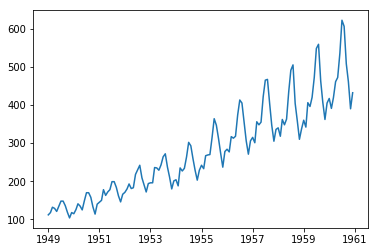

In [2]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
plt.plot(df['Month'], df['#Passengers'])

## Build two models and an error function

In [3]:
model_es = ExponentialSmoothing()
model_pr = Prophet()

def error_func(y_true, y_hat):
    # Mean absolute percentage error
    y_true, y_hat = np.array(y_true), np.array(y_hat)
    return 100. * np.mean(np.abs((y_true - y_hat)/y_true))

## Backtest the models on the data
Simulate 12-months ahead predictions done in the past

In [4]:
tic = time.time()
backtest_results_es = model_es.backtest(df, '#Passengers', 'Month', 'month', 
                                        datetime(1955, 1, 1), 12, error_func)
tac = time.time()
print('Backtested Exponential Smoothing in %.2f s.' % (tac-tic))


tic = time.time()
backtest_results_pr = model_pr.backtest(df, '#Passengers', 'Month', 'month', 
                                        datetime(1955, 1, 1), 12, error_func)
tac = time.time()
print('Backtested Prophet in %.2f s.' % (tac-tic))

Backtested Exponential Smoothing in 40.50 s.
Backtested Prophet in 89.35 s.


## Plot backtesting results

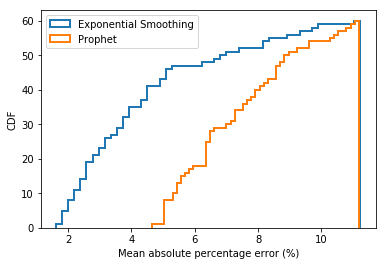

In [5]:
plt.hist(backtest_results_es, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Exponential Smoothing');
plt.hist(backtest_results_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')
plt.legend(loc=2)

## Let's make an actual forecast!
Since Exponential Smoothing is better in backtests, let's use this one.

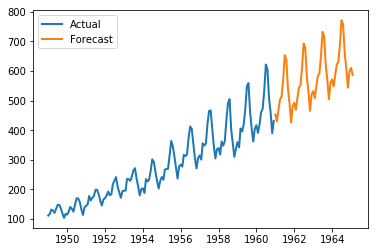

In [8]:
model_es.fit(df, '#Passengers', 'Month', 'month')
pred_df = model_es.predict(n = 50)

plt.plot(df['Month'], df['#Passengers'], lw=2, label='Actual')
plt.plot(pred_df['Month'], pred_df['yhat'], lw=2, label='Forecast')
plt.legend()